# Quantify protein nucleation rate from a kymograph v. 1.1

version: 2 March 2021

Artur Kaczmarczyk<sup>1</sup>, Ondrej Belan<sup>2</sup>, Matt Netwon<sup>1</sup>, Simon Boulton<sup>2</sup>, David Rueda<sup>1</sup> 
<br>*<sup>1</sup>Single Molecule Imaging Group, Imperial College London/ MRC LMS , UK
<br>*<sup>2</sup>*Francis Crick Institute, London UK*

a.kaczmarczyk@imperial.ac.uk 


--------------

This script was used in the following study:

Ondrej Belan et al., "*Single-molecule analysis reveals cooperative stimulation of Rad51 filament nucleation and growth by mediator proteins*", Molecular Cell, 2021, https://doi.org/10.1016/j.molcel.2020.12.020.

--------------

In this script, proteins filaments that nucleate and elongate on a tethered DNA are tracked on a kymograph. 

The image (imported as a raw .tiff file) is cropped, median-filtered and smoothed. Subsequently, a peak-finder function scans each timeframe (vertical line) of the kymograph. The number of detected peaks is then plotted as a function of time. Finally, the dependency is fitted with a single exponential function to obtain a nucleation rate.

In the example shown below, a non-labelled protein nucleates and further elongates as filaments on a eGFP-RPA-coated lambda-DNA (blue). As the protein outcompetes RPA from the DNA, broadening dark patches are observed on the imported kymograph. In order to quantify the number of nucleation events, the image's intensities were reversed allowing to detect the dark spots as peaks.


Updates:
- peaks indexes that have intensities lower than a "background threshold" are eliminated. they were obscuring the detection of nuclei in the first few time frames

In [1]:
# Load the libraries

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})

import numpy as np
import numpy.ma as ma
import sys
import os

from lumicks import pylake

from mpl_toolkits.mplot3d import Axes3D  #plot for visual purposes, can be omitted 
from scipy.optimize import curve_fit 

import peakutils
from peakutils.plot import plot as pplot

from skimage.io import imread             #loading tiff files

#from scipy.signal import find_peaks      #another method that detects peaks based on their prominence


%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


## Load the .tiff file
Put the script file in the same location as the .tiff file that is going to be analyzed. The kymograph file will be automatically loaded to the workspace.

In [2]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'Peaks')  #saving some images in a new folder
if not os.path.exists(final_directory):
     os.makedirs(final_directory)
        

filenames = os.listdir(current_directory)  
Filenames = []  
for filename in filenames:                      # select .h5 files only
    if filename[-5:] == '.tiff':
        Filenames.append(filename)


filename = str(Filenames[0])
image_stack = imread(filename)
[row,col,color] = image_stack.shape

print('Imported filename: ' + filename)
print('Number of pixels in each scan (rows): ' + str(row))
print('Number of scans (frames,columns): ' + str(col))
print('Number of colors: ' + str(color))

Imported filename: R51_4.tiff
Number of pixels in each scan (rows): 418
Number of scans (frames,columns): 252
Number of colors: 3


## Select Red (0), Green (1) or Blue (2) channel
## Define the level of filterring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(418, 252, 3)
(418, 252)
Maximal intensity in the selected channel: 790
Maximal intensity in the selected channel: 790


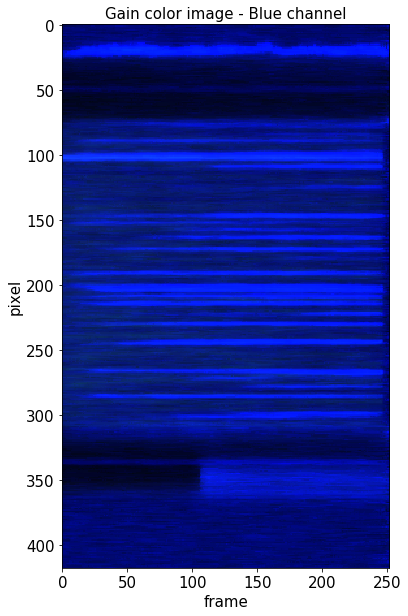

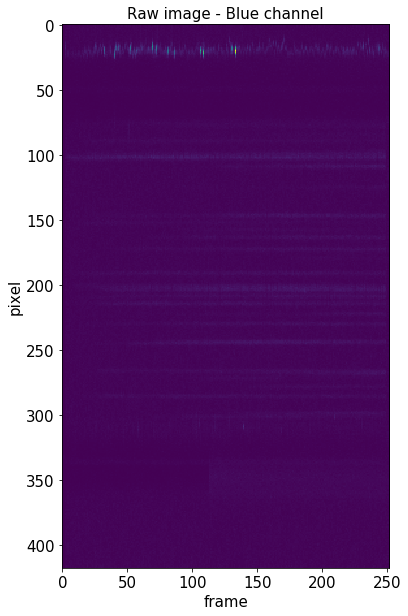

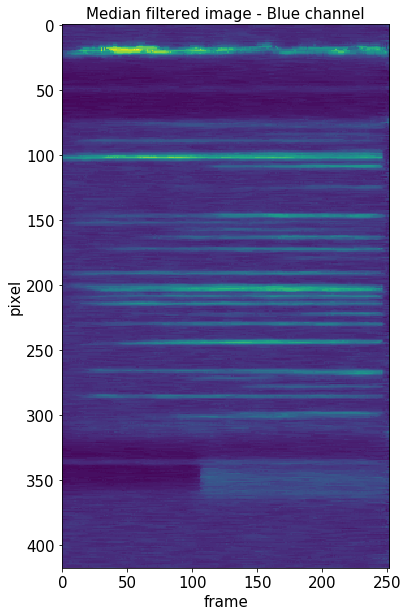

In [3]:
channel = 2

if channel == 0:
    loaded_img = np.int32(image_stack[:,:,0])
    str_color = str('Red channel')
elif channel == 1:
    loaded_img = np.int32(image_stack[:,:,1])
    str_color = str('Green channel')
else:
    loaded_img = np.int32(image_stack[:,:,2])
    str_color = str('Blue channel')

#image_rgb = loaded_img
image_rgb = np.int32(image_stack)

# Define base colour levels
level_red = 1
level_green = 1
level_blue = 10    # increase the contrast

# Define Filter and Line Summing
level_hfilter = 15
level_vfilter = 1
level_hsum = 1      # keep as 1
level_vsum = 1      # keep as 1

# Adjusted colour levels
level_red  /= (level_hsum*level_vsum)
level_green /= (level_hsum*level_vsum)
level_blue /= (level_hsum*level_vsum)    
        
    
##Adjust colour balance
image_rgb[:,:,0] = image_rgb[:,:,0]*level_red
image_rgb[:,:,1] = image_rgb[:,:,1]*level_green
image_rgb[:,:,2] = image_rgb[:,:,2]*level_blue


##Filters
#Horizontal Filter
def horizontal_med_filter(rgb_image, size): 
    filt_image = rgb_image
    w = rgb_image.shape[1]  #size of x (pixels?)
    n = 0
    
    for y in range(0,w):
        filt_image[:,y,:] = np.median(rgb_image[:,n:n+size], axis=1) 
        n += 1
    
    return(filt_image)

#Vertical Filter
def vertical_med_filter(rgb_image, size): 
    filt_image = rgb_image
    h = rgb_image.shape[0]
    n = 0
    
    for y in range(0,h):
        filt_image[y,:,:] = np.median(rgb_image[n:n+size,:], axis=0)
        n += 1
    
    return(filt_image)

#Sum Horizontal
def sum_horizontal(rgb_image, nlines):
    image_hsum = rgb_image
    w = rgb_image.shape[1]  #size of x (pixels?)
    n = 0
    
    for y in range(0,w):
        image_hsum[:,y,:] = rgb_image[:,n:n+nlines,:].sum(axis=1)
        n += nlines
    
    image_hsum = image_hsum[:,:int(w/nlines),:]
    
    return(image_hsum)

#Sum Vertical
def sum_vertical(rgb_image, nlines):
    image_vsum = rgb_image
    h = rgb_image.shape[0]
    n = 0
    
    for y in range(0,h):
        image_vsum[y,:,:] = rgb_image[n:n+nlines,:,:].sum(axis=0)
        n += nlines
    
    image_vsum = image_vsum[:int(h/nlines),:,:]
    
    return(image_vsum)

def process_image(rgb_image, level_hfilter, level_vfilter, level_hsum, level_vsum):
    image_hf = horizontal_med_filter(rgb_image, level_hfilter)
    image_hf_vf = vertical_med_filter(image_hf, level_vfilter)
    image_hf_vf_sh = sum_horizontal(image_hf_vf, level_hsum)
    image_hf_vf_sh_vh = sum_vertical(image_hf_vf_sh, level_vsum)
    return(image_hf_vf_sh_vh)

processed_image = process_image(image_rgb, level_hfilter, level_vfilter, level_hsum, level_vsum)

print(processed_image.shape)   
print(loaded_img.shape)
    

    
#fig, ax = plt.subplots(figsize=(40, 10))
#ax.imshow(processed_image) 
fig = plt.figure(figsize=(20,10))
plt.imshow(processed_image)
plt.title(str('Gain color image - ') + str_color)
plt.xlabel("frame")
plt.ylabel("pixel")
plt.savefig("GainColor_"+filename[:-5] + '.png', dpi=300, bbox_inches='tight')
       
    
raw_img =  loaded_img
fig = plt.figure(figsize=(20,10))
plt.imshow(loaded_img[:,:])
plt.title(str('Raw image - ') + str_color)
plt.xlabel("frame")
plt.ylabel("pixel")
plt.savefig("Raw_"+filename[:-5] + '.png', dpi=300, bbox_inches='tight')

loaded_img = processed_image[:,:,2]
# Get a sense of the pixel values in the kymos. 
max_px = np.max(loaded_img)
print('Maximal intensity in the selected channel: ' + str(max_px))
print('Maximal intensity in the selected channel: ' + str(np.max(processed_image[:,:,2])))

#csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

fig = plt.figure(figsize=(20,10))
plt.imshow(loaded_img[:,:])
plt.title(str('Median filtered image - ') + str_color)
plt.xlabel("frame")
plt.ylabel("pixel")
plt.savefig("Median_filtered_" +filename[:-5] + '.png', dpi=300, bbox_inches='tight')

## Crop and smooth the area of interest 

Define MANUALLY the pixel range (in y-axis) to be analyzed. Remove the area with the bead. 

Smooth the image, first along the y axis (along the DNA contour) and then along the x axis (in time)

Line time = 5 s.
Total acquisition time: 21 minutes
Maximal intensity in the selected channel: 534.4444444444443


<Figure size 432x288 with 0 Axes>

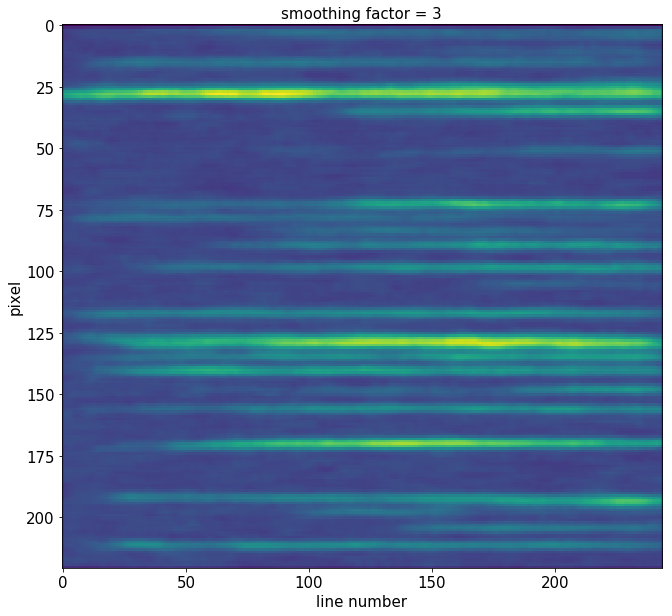

In [4]:
# Smoothing function

smoothing_factor = 3
#smoothing_factor_horizontal = 5

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


intensities_filtered_2 = []

# Type the acuisition rate (time per one kymograph line) and select the part of the kymograph to be analyzed


line_time = 5    # seconds (this parameter can be deduced from the standard script that imports kymographs from a .h5 file)

crop_top = 75      # pixel
crop_bottom = 295   # pixel
crop_left = 1      # frame number (first frames removed as some kymographs contain the transfer from the buffer channel to the protein channel)
crop_right = 245    # frame number





print('Line time = ' + str(line_time) + ' s.')
print('Total acquisition time: '+ str(round(col*line_time/60))+' minutes')


#intensities_filtered = np.zeros([crop_bottom-crop_top,1])
intensities_filtered = []
intensities_filtered = np.zeros([crop_bottom-crop_top,1])
intensities_filtered_2 = np.zeros([1, crop_right-crop_left])


# Smooth each scan of the kymograph (vertically)
for i in np.arange(crop_right-crop_left):
    
    intensity = loaded_img[crop_top:crop_bottom,i+crop_left]  
    smooth_vertical = smooth(intensity,smoothing_factor)[np.newaxis]
    smooth_vertical_transp = smooth_vertical.T
    intensities_filtered = np.append(intensities_filtered, smooth_vertical_transp, axis=1)

    
# Smooth each scan of the kymograph (horizontally)
for j in np.arange(crop_bottom-crop_top):
    
    intensity_2 = intensities_filtered[j,1:]
    #yhat = savgol_filter(intensity, 7, 3) # window size 51, polynomial order 3
    smooth_horizontal = smooth(intensity_2,smoothing_factor)
    intensities_filtered_2 = np.append(intensities_filtered_2, [smooth_horizontal],axis=0)
    
## (TO BE IMPROVED - seems like the smooothing doesnt work weel on the very first line)



# Plot and save the chopped images
plt.clf()   # Clear figure
fig = plt.figure(figsize=(20,10))

# Reverse the intensities
max_px2 = np.max(intensities_filtered_2)
intensities_negative = max_px2 - intensities_filtered_2
plt.imshow(intensities_filtered_2)
print('Maximal intensity in the selected channel: ' + str(max_px2))
plt.title('smoothing factor = '+str(smoothing_factor))
plt.xlabel("line number")
plt.ylabel("pixel")
plt.savefig(filename[:-5]+ str('crop_and_smooth') + '.png', dpi=300, bbox_inches='tight')


## Plot the intensities of the selected frames (quality control).
## Use the peak-finding function & plot the number of detected peaks in each frame



122.2222222222222


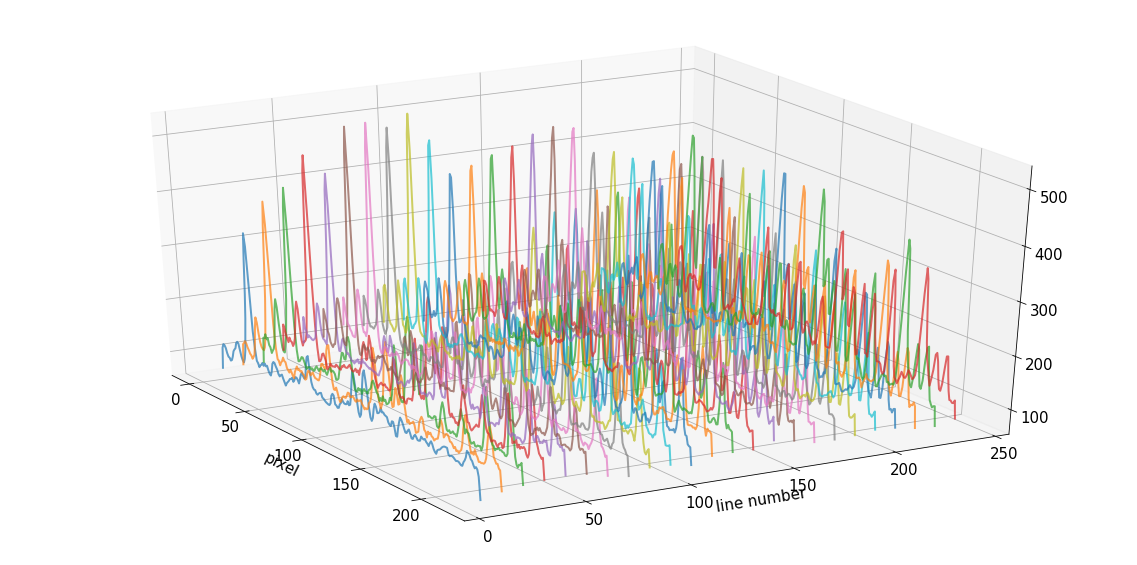

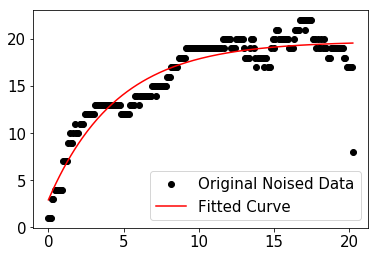

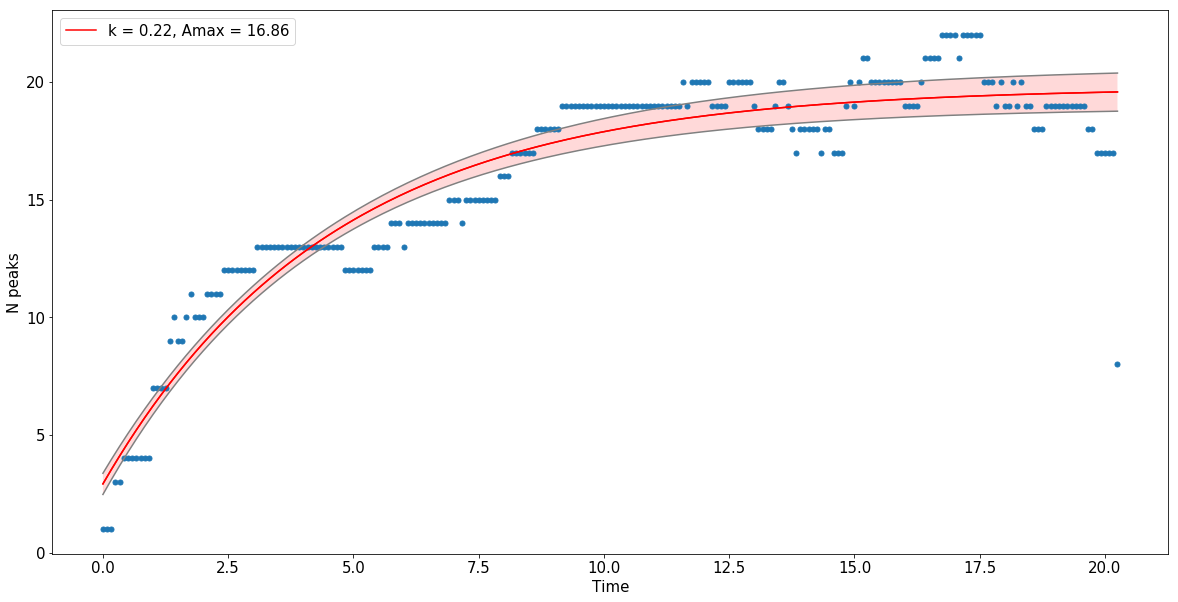

In [7]:
raw_data_crop = loaded_img[crop_top:crop_bottom,crop_left:crop_right]


threshold_peak = 0.2

# Quick estimation of the baseline intensity. Peaks that have intensities lower than this baseline are not included in the analysis
background = np.median(intensities_filtered_2[1:,1:50])
print(background)


contour = np.arange(crop_bottom-crop_top)
frames = np.arange(crop_right-crop_left)  
z_line = np.empty(crop_bottom-crop_top)   # for 3D plotting purposes

nuclei = []
m = 0


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

# Set rotation angle to 30 degrees
ax.view_init(azim=-30)



for k in np.arange(crop_right-crop_left):
    
    #line = 1-(intensities_filtered_2[1:,k]/np.amax(intensities_filtered_2[1:,k]))  #normalisation
    #line = intensities_filtered_2[1:,k]/np.amax(intensities_negative[1:,:])  #normalisation
    
    line = intensities_filtered_2[1:,k]

    peaks = peakutils.indexes(line, threshold_peak, min_dist=3) 
    intensities_peaks = intensities_filtered_2[peaks,k]
    
    # Eliminate peaks which absolute intensities is close to the background level
    newArr = intensities_peaks[intensities_peaks > 1.2*background]
    nuclei = np.append(nuclei,len(newArr))
    
    #Different peak finder
    #yyy, _  = find_peaks(line, prominence=1)
    #nuclei = np.append(nuclei,len(yyy))
    
    # Plot every 100th intensity profile
    if k % 10 == 0 and k!=0:      
        m += 1
        z_line.fill(k)
        ax.plot(contour,z_line,line,linewidth = '2',alpha=0.7)
        z_line = np.empty(crop_bottom-crop_top)

        
        plt.ylabel("line number")
        plt.xlabel("pixel")
        
plt.savefig(filename[:-5]+ str('_Intensities_') + '.png', dpi=300, bbox_inches='tight')
plt.savefig(filename[:-5]+ str('_Intensities_') + '.pdf', dpi=300, bbox_inches='tight')
    
    
# Plot the number of detected peaks in each frame and fit with single exponential 


def func(x, a, b, c):
    return a * (1-np.exp(-b * x)) + c


time = frames*line_time/60

time_fit = time
nuclei_fit = nuclei

x = np.linspace(0,len(nuclei_fit))
x = time

y = func(x, 25, 0.5, 0)
yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, time_fit[:], nuclei_fit[:])
y  = func(x, popt[0], popt[1], popt[2])
y1 = func(x, popt[0] + pcov[0,0]**0.5, popt[1] - pcov[1,1]**0.5, popt[2] + pcov[2,2]**0.5)
y2 = func(x, popt[0] - pcov[0,0]**0.5, popt[1] + pcov[1,1]**0.5, popt[2] - pcov[2,2]**0.5)


plt.figure()
#plt.plot(, yn)
plt.plot(time_fit, nuclei_fit, 'ko', label="Original Noised Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,10))
plt.plot(time,nuclei,'.',markersize=10)
plt.plot(x, func(x, *popt), 'r-', label=(str("k = ")+str(round(popt[1],2)))+ ", Amax = "+str(round(popt[0],2)))
plt.xlabel("Time")
plt.ylabel("N peaks")
#plt.title(str('amax = ')+ str(popt[0]) + print(u"\u00B1") + str(pcov[0]) + str(' k = ') + popt[1] + print(u"\u00B1") + str(pcov[1]))
plt.legend()



plt.plot(x, y, 'r-')
plt.plot(x, y1, '-',color='gray')
plt.plot(x, y2, '-',color='gray')
plt.fill_between(x, y1, y2, facecolor="red", alpha=0.15)


plt.savefig(filename[:-5]+ str('_Peaks') + '.png', dpi=300, bbox_inches='tight')
plt.savefig(filename[:-5]+ str('_Peaks') + '.pdf', dpi=300, bbox_inches='tight')
np.savetxt('Peaks_' + filename[:-5] + '.csv',np.c_[time, nuclei], delimiter=",")    # exports the peak position
np.savetxt('Fit_Peaks_' + filename[:-5] + '.csv',np.c_[time_fit, nuclei_fit], delimiter=",")    # exports the peak position
np.savetxt('Fit_Errors_' + filename[:-5] + '.csv',np.c_[x,y,y1,y2], delimiter=",")    # exports the peak position



## Checking how the peak finder behaves

In [ ]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'Peaks')
if not os.path.exists(final_directory):
     os.makedirs(final_directory)
        


for m in np.arange(crop_right-crop_left-1):
    
    #line = 1-(intensities_filtered_2[1:,m]/np.amax(intensities_filtered_2[1:,m]))  #normalisation
    #line = intensities_negative[1:,m]
    line = intensities_filtered_2[1:,m]
    #reverse_raw_data = np.max(processed_image[:,:,2]) -raw_data_crop[:,m]
    reverse_raw_data = raw_data_crop[:,m]
    #line = 1-(intensity[1:,m+crop_left]/np.amax(intensities_filtered_2[1:,m+crop_left]))  #normalisation
    indexes_data = peakutils.indexes(line, threshold_peak, min_dist=5) 
    peaks_data = line[indexes_data]
    nuclei = np.append(nuclei,len(indexes_data))
    #peaks_method2, _  = find_peaks(line, prominence=2) #width, threshold, 
      
    # Plot every 5th intensity profile
    if m % 5 == 0:      

        fig = plt.figure(figsize=(20,5))
        plt.plot(contour, line, linewidth = '3',color='green', label='smoothed data')
        
        #plt.plot(contour, reverse_raw_data, linewidth = '2',color='silver', label='raw data')
        plt.title('frame = ' + str(m))
        plt.scatter(indexes_data,peaks_data, marker=(5, 1), s = 200, color = 'red', label='peak detector with threshold')
        #plt.plot(peaks_method2, line[peaks_method2], "or", label='peak detector with prominence')
        plt.axhline(y=1.2*background, color='grey', linestyle='--')


        plt.legend(framealpha=1, frameon=True);
        
        #save_results_to = '/Users/S/Desktop/Results/'
        #plt.savefig(final_directory + filename[:-5] + str('crop_and_smooth') + '.png', dpi=300, bbox_inches='tight') 
        
        savepath = os.path.join(final_directory, filename[:-5] + str('crop_and_smooth_frame_' + str(m) + '.png'))
        plt.savefig(savepath, dpi=300, bbox_inches='tight') 
